In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

import datetime
import matplotlib
from matplotlib import pyplot

In [2]:
prediction_trend_data = [] 
input_numeric_columns = []
input_categorical_columns = []
output_columns = []

normalize = False
dfOriginal = pd.read_csv('../Data/V1.1FeaturesWithLabelsTestRegion220131201To20180430.csv', parse_dates=['Date'], low_memory=False)
df = dfOriginal
all_columns = list(df)
numeric_regex = re.compile("n_*")
input_numeric_columns = list(filter(numeric_regex.match, all_columns))
categorical_regex = re.compile("c_*")                               
input_categorical_columns = list(filter(categorical_regex.match, all_columns))
output_regex = re.compile("o_*")                               
output_columns = list(filter(output_regex.match, all_columns))
metadata_columns = ["Lat", "Lon", "UnifiedRegion", "Date"]
df = df[input_numeric_columns+input_categorical_columns+output_columns+prediction_trend_data+metadata_columns]
    
if(normalize):
    #normalize data; not necessary for xgboost
    scaler = Normalizer()
    dontNormalize = input_categorical_columns + output_columns + prediction_trend_data + metadata_columns
    df.loc[:, ~df.columns.isin(dontNormalize)] = scaler.fit_transform(df.loc[:, ~df.columns.isin(dontNormalize)])

In [5]:
df = df[df['o_Day1DangerAboveTreeline']!='no-data']
df = df[df['o_Day1DangerNearTreeline']!='no-data']
df = df[df['o_Day1DangerBelowTreeline']!='no-data']

df = df[df['o_Day1DangerAboveTreeline']!='Extreme']
df = df[df['o_Day1DangerNearTreeline']!='Extreme']
df = df[df['o_Day1DangerBelowTreeline']!='Extreme']

In [6]:
df['DayOfYear'] = df['Date'].dt.dayofyear

In [7]:
#clean mising values
mappingMissingValues = {-9999:np.nan}
df = df.replace(mappingMissingValues)
df.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,o_WindSlab_OctagonBelowTreelineNorthWest,o_WindSlab_OctagonBelowTreelineSouth,o_WindSlab_OctagonBelowTreelineSouthEast,o_WindSlab_OctagonBelowTreelineSouthWest,o_WindSlab_OctagonBelowTreelineWest,Lat,Lon,UnifiedRegion,Date,DayOfYear
0,0.000,4.999330,0.000,4.865368,0.000,4.443436,0.000,4.092617,0.000,3.976272,...,0.0,0.0,0.0,0.0,0.0,45.325032,-121.768112,Mt Hood,2017-03-03,62
1,0.000,4.518329,0.000,4.482395,0.000,4.006628,0.000,3.611800,0.000,3.551168,...,0.0,0.0,0.0,0.0,0.0,45.345059,-121.625313,Mt Hood,2017-03-03,62
2,0.000,5.120650,0.000,4.874457,0.000,4.539024,0.000,4.305095,0.000,4.023225,...,0.0,0.0,0.0,0.0,0.0,45.425373,-121.796703,Mt Hood,2017-03-03,62
3,0.125,3.892266,0.250,3.544865,0.375,3.200535,0.375,3.295267,0.375,3.794158,...,0.0,0.0,0.0,0.0,0.0,45.825963,-121.911672,Cascade West - South,2017-03-03,62
4,0.000,4.370156,0.125,3.860218,0.125,3.413179,0.250,3.375394,0.250,3.773900,...,0.0,0.0,0.0,0.0,0.0,45.846022,-121.768148,Cascade West - South,2017-03-03,62


In [9]:
splitBySeason = True
testAsMostRecent = False
yColumns = ['o_Day1DangerAboveTreeline']
yNearColumn = ['o_Day1DangerNearTreeline']
yBelowColumn = ['o_Day1DangerBelowTreeline']

if(splitBySeason):
    if(testAsMostRecent):
        df_train = df[df['Date'] < datetime.datetime(2017, 5, 1)] 
        df_test = df[df['Date'] > datetime.datetime(2017, 5, 1)]
    else:
        df_train = df[(df['Date'] < datetime.datetime(2016, 5, 1)) | (df['Date'] > datetime.datetime(2017, 5, 1))] 
        df_test = df[(df['Date'] > datetime.datetime(2016, 5, 1)) & (df['Date'] < datetime.datetime(2017, 5, 1))]
    
    y_Above_train = df_train[yColumns + metadata_columns]
    y_Near_train = df_train[yNearColumn + metadata_columns]
    y_Below_train = df_train[yBelowColumn + metadata_columns]
    
    y_Above_test = df_test[yColumns + metadata_columns]
    y_Near_test = df_test[yNearColumn + metadata_columns]
    y_Below_test = df_test[yBelowColumn + metadata_columns]
    
    #feature engineer date
    #add_datepart(df_train, 'Date')
    #add_datepart(df_test, 'Date')
    date_columns = ['DayOfYear']
    
    #same x input trained to get a different output
    X_Above_train = X_Near_train = X_Below_train = df_train[input_numeric_columns+input_categorical_columns+date_columns]
    X_Above_test = X_Near_test = X_Below_test = df_test[input_numeric_columns+input_categorical_columns+date_columns]
    
   
    
else:
    #random stratified split
    X = df[input_numeric_columns+input_categorical_columns]
    
    yAbove=df[yColumns + metadata_columns]
    X_Above_train, X_Above_test, y_Above_train, y_Above_test = train_test_split(X, yAbove, stratify=yAbove["o_Day1DangerAboveTreeline"], test_size=0.20, random_state=1)
    
    yNear=df[yNearColumn+metadata_columns]
    X_Near_train, X_Near_test, y_Near_train, y_Near_test = train_test_split(X, yNear, stratify=yNear['o_Day1DangerNearTreeline'], test_size=0.20, random_state=1)
    
    yBelow=df[yBelowColumn+metadata_columns]
    X_Below_train, X_Below_test, y_Below_train, y_Below_test = train_test_split(X, yBelow, stratify=yBelow['o_Day1DangerBelowTreeline'], test_size=0.20, random_state=1)

In [10]:
X_Below_train.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev7DayWindSlabLikeliness8InPast,c_r_Prev3DayFreezeThawLikeliness9InPast,c_r_Prev7DayFreezeThawLikeliness9InPast,c_r_Prev3DayWindSlabLikeliness9InPast,c_r_Prev7DayWindSlabLikeliness9InPast,c_r_Prev3DayFreezeThawLikeliness10InPast,c_r_Prev7DayFreezeThawLikeliness10InPast,c_r_Prev3DayWindSlabLikeliness10InPast,c_r_Prev7DayWindSlabLikeliness10InPast,DayOfYear
12648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98
12649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98
12650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98
12651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98
12652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98


In [11]:
y_Above_train['o_Day1DangerAboveTreeline'].value_counts()

Moderate        36016
Considerable    27156
Low             23843
High             6084
Name: o_Day1DangerAboveTreeline, dtype: int64

In [12]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')

In [15]:
%%time
gbmgpu.fit(X_Above_train.values, 
        y_Above_train[yColumns].values.ravel(), 
        eval_set=[(X_Above_test.values, y_Above_test[yColumns].values.ravel())],
        early_stopping_rounds=15,
        )

TypeError: fit() got an unexpected keyword argument 'learning_rate'

In [12]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   48.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 34.3min
[Parallel(n_jobs=6)]: Done  39 out of  45 | elapsed: 111.0min remaining: 17.1min
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed: 174.7min finished


Best: -0.094334 using {'num_leaves': 511, 'learning_rate': 0.1}
-0.433086 (0.002184) with: {'num_leaves': 15, 'learning_rate': 0.1}
-0.307489 (0.000903) with: {'num_leaves': 31, 'learning_rate': 0.1}
-0.204446 (0.000706) with: {'num_leaves': 63, 'learning_rate': 0.1}
-0.133307 (0.001184) with: {'num_leaves': 127, 'learning_rate': 0.1}
-0.099393 (0.001245) with: {'num_leaves': 255, 'learning_rate': 0.1}
-0.094334 (0.001332) with: {'num_leaves': 511, 'learning_rate': 0.1}
-0.102743 (0.001108) with: {'num_leaves': 1023, 'learning_rate': 0.1}
-0.112811 (0.001000) with: {'num_leaves': 2047, 'learning_rate': 0.1}
-0.114595 (0.000874) with: {'num_leaves': 4095, 'learning_rate': 0.1}


In [29]:
%%time
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'bagging_fraction': [.5, .8],
    'num_leaves': [200, 350, 500],
    'feature_fraction': [.75, 1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0, 1],
    'class_weight': [None, 'balanced']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 31.7min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 40.0min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 59.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 72.0min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 83.0min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 98.5min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 126.3min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 145.8min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 163.4min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 182.9min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 209.0min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 231.6min
[Parallel(n_jobs=6

Best: -0.037233 using {'learning_rate': 0.1, 'class_weight': 'balanced', 'num_leaves': 500, 'reg_alpha': 0, 'feature_fraction': 0.75, 'bagging_fraction': 0.5, 'reg_lambda': 0}
-0.064959 (0.001313) with: {'learning_rate': 0.1, 'class_weight': None, 'num_leaves': 200, 'reg_alpha': 0, 'feature_fraction': 0.75, 'bagging_fraction': 0.5, 'reg_lambda': 0}
-0.069297 (0.001487) with: {'learning_rate': 0.1, 'class_weight': None, 'num_leaves': 200, 'reg_alpha': 0, 'feature_fraction': 0.75, 'bagging_fraction': 0.5, 'reg_lambda': 1}
-0.076621 (0.001225) with: {'learning_rate': 0.1, 'class_weight': None, 'num_leaves': 200, 'reg_alpha': 1, 'feature_fraction': 0.75, 'bagging_fraction': 0.5, 'reg_lambda': 0}
-0.079367 (0.001402) with: {'learning_rate': 0.1, 'class_weight': None, 'num_leaves': 200, 'reg_alpha': 1, 'feature_fraction': 0.75, 'bagging_fraction': 0.5, 'reg_lambda': 1}
-0.044995 (0.001429) with: {'learning_rate': 0.1, 'class_weight': None, 'num_leaves': 350, 'reg_alpha': 0, 'feature_fraction

In [40]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu', 
                            learning_rate=.01, num_class=4, num_leaves=500,
                            reg_alpha=0, reg_lambda=0, feature_fraction=.75,
                            bagging_fraction=.5, class_weight='balanced')

In [41]:
%%time
gbmgpu.fit(X_Above_train.values, 
        y_Above_train[yColumns].values.ravel(), 
        eval_set=[(X_Above_test.values, y_Above_test[yColumns].values.ravel())],
        early_stopping_rounds=10
        )

[1]	valid_0's multi_logloss: 1.38113
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 1.37609
[3]	valid_0's multi_logloss: 1.37126
[4]	valid_0's multi_logloss: 1.36652
[5]	valid_0's multi_logloss: 1.36206
[6]	valid_0's multi_logloss: 1.35757
[7]	valid_0's multi_logloss: 1.35335
[8]	valid_0's multi_logloss: 1.34824
[9]	valid_0's multi_logloss: 1.34388
[10]	valid_0's multi_logloss: 1.3397
[11]	valid_0's multi_logloss: 1.33595
[12]	valid_0's multi_logloss: 1.33168
[13]	valid_0's multi_logloss: 1.32734
[14]	valid_0's multi_logloss: 1.3234
[15]	valid_0's multi_logloss: 1.3195
[16]	valid_0's multi_logloss: 1.31533
[17]	valid_0's multi_logloss: 1.3111
[18]	valid_0's multi_logloss: 1.30735
[19]	valid_0's multi_logloss: 1.30328
[20]	valid_0's multi_logloss: 1.29938
[21]	valid_0's multi_logloss: 1.29573
[22]	valid_0's multi_logloss: 1.29229
[23]	valid_0's multi_logloss: 1.28903
[24]	valid_0's multi_logloss: 1.28572
[25]	valid_0's multi_logloss: 1.2822
[2

LGBMClassifier(bagging_fraction=0.5, boosting_type='gbdt',
        class_weight='balanced', colsample_bytree=1.0, device_type='gpu',
        feature_fraction=0.75, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_class=4,
        num_leaves=500, objective='multiclass', random_state=None,
        reg_alpha=0, reg_lambda=0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [78]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu', 
                            learning_rate=.01, num_class=4, num_leaves=700,
                            n_estimators = 200,
                            reg_alpha=0, reg_lambda=0, feature_fraction=.75,
                            bagging_fraction=.4, class_weight='balanced',
                            num_boost_round=1000)

In [79]:
%%time
gbmgpu.fit(X_Above_train.values, 
        y_Above_train[yColumns].values.ravel(), 
        eval_set=[(X_Above_test.values, y_Above_test[yColumns].values.ravel())],
        early_stopping_rounds=20
        
        )

C:\Users\scott\Anaconda3\envs\python35\lib\site-packages\lightgbm\engine.py:111: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.38104
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 1.37588
[3]	valid_0's multi_logloss: 1.37104
[4]	valid_0's multi_logloss: 1.36614
[5]	valid_0's multi_logloss: 1.36169
[6]	valid_0's multi_logloss: 1.35724
[7]	valid_0's multi_logloss: 1.35301
[8]	valid_0's multi_logloss: 1.34789
[9]	valid_0's multi_logloss: 1.34341
[10]	valid_0's multi_logloss: 1.33926
[11]	valid_0's multi_logloss: 1.33548
[12]	valid_0's multi_logloss: 1.33121
[13]	valid_0's multi_logloss: 1.32693
[14]	valid_0's multi_logloss: 1.32312
[15]	valid_0's multi_logloss: 1.31924
[16]	valid_0's multi_logloss: 1.3149
[17]	valid_0's multi_logloss: 1.31058
[18]	valid_0's multi_logloss: 1.30688
[19]	valid_0's multi_logloss: 1.30275
[20]	valid_0's multi_logloss: 1.29885
[21]	valid_0's multi_logloss: 1.29525
[22]	valid_0's multi_logloss: 1.29182
[23]	valid_0's multi_logloss: 1.28861
[24]	valid_0's multi_logloss: 1.28519
[25]	valid_0's multi_logloss: 1.2816

[213]	valid_0's multi_logloss: 1.01701
[214]	valid_0's multi_logloss: 1.01682
[215]	valid_0's multi_logloss: 1.01635
[216]	valid_0's multi_logloss: 1.0158
[217]	valid_0's multi_logloss: 1.01525
[218]	valid_0's multi_logloss: 1.01499
[219]	valid_0's multi_logloss: 1.01467
[220]	valid_0's multi_logloss: 1.01432
[221]	valid_0's multi_logloss: 1.01384
[222]	valid_0's multi_logloss: 1.01319
[223]	valid_0's multi_logloss: 1.01265
[224]	valid_0's multi_logloss: 1.01224
[225]	valid_0's multi_logloss: 1.01171
[226]	valid_0's multi_logloss: 1.01143
[227]	valid_0's multi_logloss: 1.01105
[228]	valid_0's multi_logloss: 1.01086
[229]	valid_0's multi_logloss: 1.01069
[230]	valid_0's multi_logloss: 1.01026
[231]	valid_0's multi_logloss: 1.00976
[232]	valid_0's multi_logloss: 1.00957
[233]	valid_0's multi_logloss: 1.00917
[234]	valid_0's multi_logloss: 1.00871
[235]	valid_0's multi_logloss: 1.00838
[236]	valid_0's multi_logloss: 1.00807
[237]	valid_0's multi_logloss: 1.00783
[238]	valid_0's multi_logl

LGBMClassifier(bagging_fraction=0.4, boosting_type='gbdt',
        class_weight='balanced', colsample_bytree=1.0, device_type='gpu',
        feature_fraction=0.75, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=200, n_jobs=-1,
        num_boost_round=1000, num_class=4, num_leaves=700,
        objective='multiclass', random_state=None, reg_alpha=0,
        reg_lambda=0, silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [80]:
resultAbove = gbmgpu.predict(X_Above_test, gbmgpu.best_iteration_)

In [81]:
gbmgpu.classes_

array(['Considerable', 'High', 'Low', 'Moderate'], dtype=object)

In [82]:
resultAbove[:10]

array([[ 0.66351389, -1.4303406 , -0.57424879, -0.60797454],
       [ 0.56701738, -1.58811472, -0.56945062, -0.60369402],
       [ 0.641122  , -1.56607914, -0.77500035, -0.71991056],
       [ 1.11950741, -0.75921091, -1.58416806, -0.71030395],
       [ 0.7430847 , -1.08341867, -1.55680218, -0.7092762 ],
       [ 1.03102254, -0.53776734, -1.6464628 , -0.84996954],
       [ 1.19493629, -0.56916168, -1.59462137, -1.08320789],
       [ 1.0881722 , -0.84106213, -1.59622477, -0.95667105],
       [-0.76179644, -1.59503254, -1.04453013, -0.80985562],
       [ 1.13064585, -0.14191632, -1.68748008, -1.10345609]])

In [83]:
best_preds = [np.argmax(line) for line in resultAbove]

In [84]:
best_preds_df = pd.DataFrame(best_preds, columns=['o_Day1DangerAboveTreeline'])

In [85]:
best_preds_df.head()

,o_Day1DangerAboveTreeline
0,0
1,0
2,0
3,0
4,0


In [86]:
mapping = {0:'Considerable', 1:'High', 2:'Low', 3:'Moderate'}
best_preds_df = best_preds_df.replace({'o_Day1DangerAboveTreeline': mapping})
best_preds_df['o_Day1DangerAboveTreeline'].head()

0    Considerable
1    Considerable
2    Considerable
3    Considerable
4    Considerable
Name: o_Day1DangerAboveTreeline, dtype: object

Accuracy: 0.5609939131159843
Classification Report
              precision    recall  f1-score   support

Considerable       0.46      0.60      0.52     12692
        High       0.44      0.17      0.24      4056
         Low       0.92      0.71      0.80      6383
    Moderate       0.57      0.58      0.57     12848

 avg / total       0.58      0.56      0.56     35979

Normalized confusion matrix
Confusion matrix, without normalization


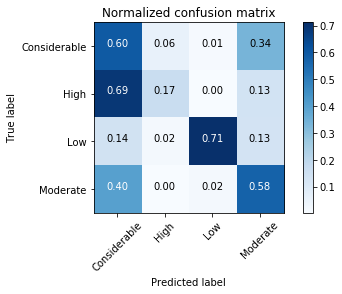

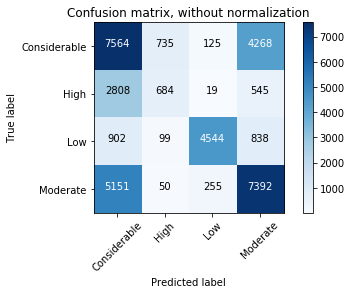

In [87]:
evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], best_preds_df)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], best_preds_df)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [50]:
%%time
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'bagging_fraction': [.4,.5],
    'num_leaves': [500, 700],
    'feature_fraction': [.5, .75],
    'class_weight': ['balanced']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 30.3min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 44.4min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 59.7min
[Parallel(n_jobs=6)]: Done  34 out of  40 | elapsed: 70.4min remaining: 12.4min
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed: 80.0min finished


Best: -0.033907 using {'feature_fraction': 0.75, 'bagging_fraction': 0.4, 'num_leaves': 700, 'learning_rate': 0.1, 'class_weight': 'balanced'}
-0.038627 (0.001169) with: {'feature_fraction': 0.5, 'bagging_fraction': 0.4, 'num_leaves': 500, 'learning_rate': 0.1, 'class_weight': 'balanced'}
-0.034951 (0.001273) with: {'feature_fraction': 0.5, 'bagging_fraction': 0.4, 'num_leaves': 700, 'learning_rate': 0.1, 'class_weight': 'balanced'}
-0.037048 (0.001371) with: {'feature_fraction': 0.75, 'bagging_fraction': 0.4, 'num_leaves': 500, 'learning_rate': 0.1, 'class_weight': 'balanced'}
-0.033907 (0.001754) with: {'feature_fraction': 0.75, 'bagging_fraction': 0.4, 'num_leaves': 700, 'learning_rate': 0.1, 'class_weight': 'balanced'}
-0.038929 (0.001031) with: {'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'num_leaves': 500, 'learning_rate': 0.1, 'class_weight': 'balanced'}
-0.034808 (0.001352) with: {'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'num_leaves': 700, 'learning_rate': 0.1, '

In [23]:
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [88]:
importances = pd.Series(gbmgpu.feature_importances_)
out = pd.concat([pd.Series(X_Above_train.columns), importances], axis=1)

In [89]:
out.columns = ['feature', 'importance']

In [92]:
out.sort_values('importance',ascending=False)[:100]

,feature,importance
341,DayOfYear,34480
65,n_r_Prev1DayPrecip,8876
89,n_r_Prev1DayPrecip1InPast,8128
111,n_r_Prev1DayPrecip2InPast,7660
50,n_f_tempAveF,7325
52,n_f_APCPsurface,7304
177,n_r_Prev1DayPrecip5InPast,7224
287,n_r_Prev1DayPrecip10InPast,7145
265,n_r_Prev1DayPrecip9InPast,6779
133,n_r_Prev1DayPrecip3InPast,6761
